# 3.03 - Analysis of lagged COB/IOB using ML models


In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pickle

from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from dtw import dtw
from datetime import time, datetime
from scipy.stats import ttest_ind, kstest
from sklearn.preprocessing import StandardScaler

from src.helper import minutes_since_night_start, cluster_colours, \
    normalise_overnight_time
from src.nights import Nights, consolidate_df_from_nights
from src.dba import dba_by_cluster
from src.reliationship_modelling import AnalyseRelationships
from src.config import FIGURES_DIR, PROCESSED_DATA_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'rb') as file:
    analyser = pickle.load(file)

df_to_compare = analyser.return_dataset_with_clusters()
cat_cols = ['night_start_date', 'cluster_label']
variables = ['cob mean', 'iob mean', 'bg mean']
scaled_cols = ['cob_mean_scaled','iob_mean_scaled', 'bg_mean_scaled']

In [34]:
df_to_compare[cat_cols + variables]

night_start_date  cluster_label  cob mean  \
id       datetime                                                        
15558575 2018-04-17 17:00:00       2018-04-17              3     16.25   
         2018-04-17 17:30:00       2018-04-17              3     58.50   
         2018-04-17 18:00:00       2018-04-17              3     49.00   
         2018-04-17 18:30:00       2018-04-17              3     51.00   
         2018-04-17 19:00:00       2018-04-17              3     37.00   
...                                       ...            ...       ...   
97417885 2018-02-18 08:30:00       2018-02-17              3      0.00   
         2018-02-18 09:00:00       2018-02-17              3      0.00   
         2018-02-18 09:30:00       2018-02-17              3      0.00   
         2018-02-18 10:00:00       2018-02-17              3      0.00   
         2018-02-18 10:30:00       2018-02-17              3      0.00   

                              iob mean  bg mean  
id       datetime                                
15558575 2018-04-17 17:00:00     2.609  145.500  
         2018-04-17 17:30:00     6.045   97.500  
         2018-04-17 18:00:00     4.101   71.500  
         2018-04-17 18:30:00     1.623   76.000  
         2018-04-17 19:00:00     1.869  110.000  
...                                ...      ...  
97417885 2018-02-18 08:30:00     0.193  116.333  
         2018-02-18 09:00:00     0.130  117.500  
         2018-02-18 09:30:00     0.152  120.000  
         2018-02-18 10:00:00     0.268  121.889  
         2018-02-18 10:30:00     0.313  127.500  

[32744 rows x 5 columns]

In [35]:
rel = AnalyseRelationships(df_to_compare.rename(columns={'cluster_label':'cluster'}), stationary=True)

In [62]:
def heatmap_regression_values(df, cob_col, iob_col, variable):
    cob_matrix = df.pivot_table(index='cluster', columns='lag', values=cob_col).round(3)
    iob_matrix = df.pivot_table(index='cluster', columns='lag', values=iob_col).round(3)
    
    vmin = min(cob_matrix.min().min(), iob_matrix.min().min())
    vmax = max(cob_matrix.max().max(), iob_matrix.max().max())
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    cmap = "YlGnBu" if variable == 'p-value' else "YlGnBu_r"

    hm0 = sns.heatmap(cob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'COB Leading BG')
    hm1 = sns.heatmap(iob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'IOB Leading BG')

    cbar = fig.colorbar(hm1.collections[0], ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label(variable)
    
    ax[0].set_xlabel('Lag)')
    ax[0].set_ylabel('Cluster')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('')
    ax[1].set_yticklabels([])
    plt.suptitle(f'Linear Regression P Values for COB and IOB Leading BG', y=1.02)
    plt.savefig(FIGURES_DIR / ('lag_heatmap_' + variable.replace(' ', '_') + '.png'), bbox_inches='tight')
    plt.show()

def heatmap_metrics(df, regressor):
    fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
    for i, m in enumerate(['r_squared', 'mse']):
        metric_matrix = df.pivot_table(index='cluster', columns='lag', values=m).round(3)
        if m == 'r_squared':
            vmin, vmax = -1, 1
            ylabel = 'Cluster'
        elif m == 'mse':
            metric_matrix = -metric_matrix  # Invert MSE for heatmap visualisation
            vmin, vmax = -0.05, 0  # Standard range for MSE for comparison
            ylabel = None
        sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap="YlGnBu_r", vmin=vmin, vmax=vmax, ax=ax[i])
        ax[i].set_title(f'{m.upper()} by Cluster and Lag')
        ax[i].set_xlabel('Lag')
        ax[i].set_ylabel(ylabel)
    plt.savefig(FIGURES_DIR / f'lag_comparison_heatmap_{regressor}.png', bbox_inches='tight')
    plt.show()

In [64]:
ols_results_cob_iob = rel.apply_ols(['cob_lagged', 'iob_lagged'])
ols_results_cob_iob = pd.DataFrame.from_records(ols_results_cob_iob)

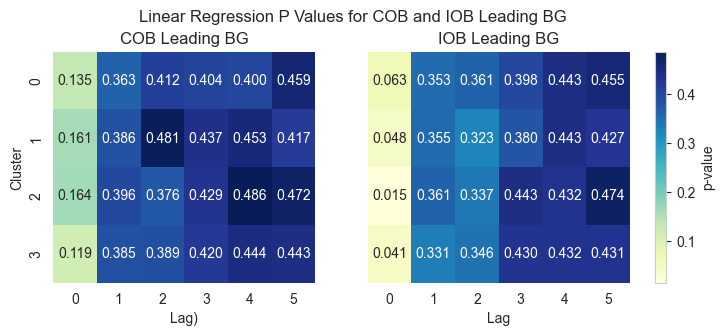

In [63]:
heatmap_regression_values(ols_results_cob_iob, 'pvalue_cob', 'pvalue_iob', 'p-value')


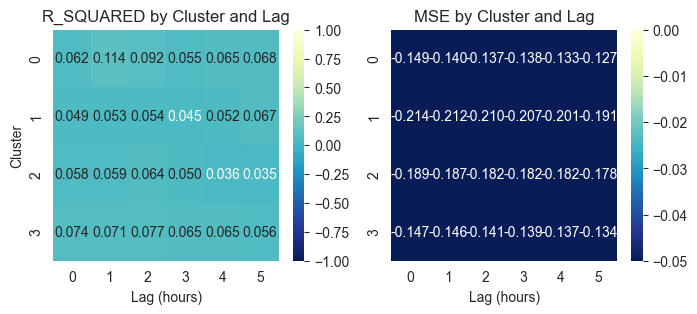

In [38]:
ols_cob_only = rel.apply_ols(['cob_lagged'])
ols_cob_only = pd.DataFrame.from_records(ols_cob_only)
heatmap_metrics(ols_cob_only, 'ols_cob')

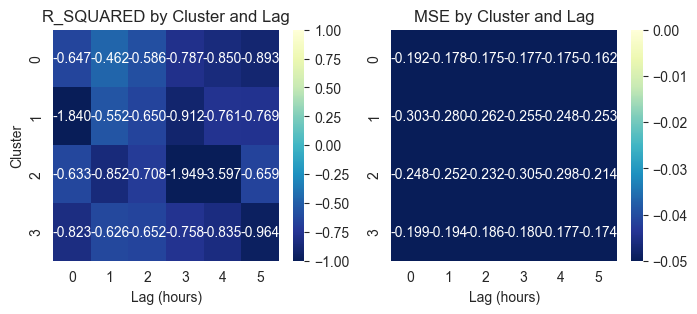

In [39]:
ols_cob_only_cv = rel.apply_cv_regression(model='LinearRegression', variables=['cob_lagged'])
ols_cob_only_cv = pd.DataFrame.from_records(ols_cob_only_cv)
heatmap_metrics(ols_cob_only_cv, 'ols_cob_cv')

And now check each of the non-linear regression models against this baseline.

Support Vector Regression (SVR) on COB lagged values


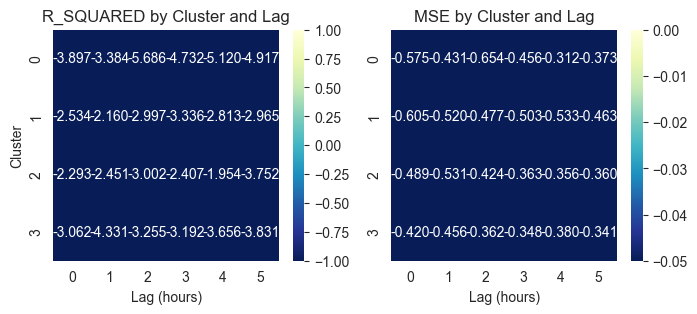

In [40]:
print('Support Vector Regression (SVR) on COB lagged values')
svm_kwargs = {'kernel': 'rbf', 'gamma': np.float64(1.0), 'epsilon': 0.5, 'C': np.float64(1000.0)}
svm_results = rel.apply_cv_regression(model='SVR', variables=['cob_lagged'], n_splits=5, **svm_kwargs)
svm_results = pd.DataFrame.from_records(svm_results)
heatmap_metrics(svm_results, 'svm_cob_cv')

Decision Tree on COB lagged values


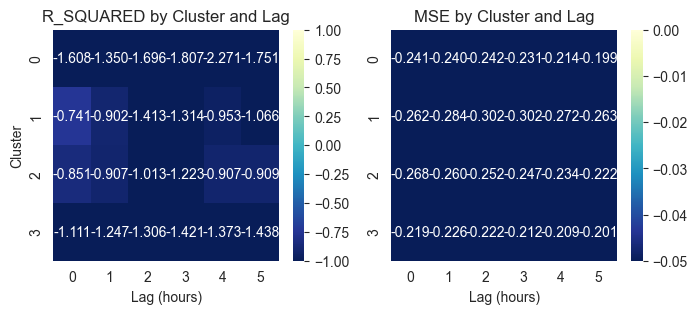

In [41]:
print('Decision Tree on COB lagged values')
dt_kwargs = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}
dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor', variables=['cob_lagged'], n_splits=5, **dt_kwargs)
dt_results = pd.DataFrame.from_records(dt_results)
heatmap_metrics(dt_results, 'dt_cob_cv')

Random Forest on COB lagged values


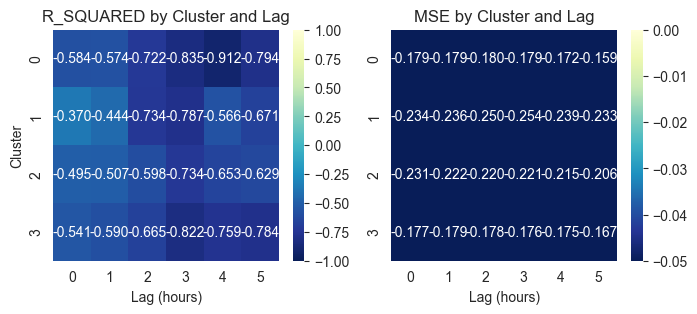

In [42]:
print('Random Forest on COB lagged values')
rf_kwargs = {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
rf_results = rel.apply_cv_regression(model='RandomForestRegressor', variables=['cob_lagged'], n_splits=5, **rf_kwargs)
rf_results = pd.DataFrame.from_records(rf_results)
heatmap_metrics(rf_results, 'rf_cob_cv')

In [45]:
print('Linear Regression on IOB lagged values')
iob_linear_results = rel.apply_cv_regression(model='LinearRegression',
                                          variables=['iob_lagged'])
iob_linear_results = pd.DataFrame.from_records(iob_linear_results)

print('Support Vector Regression (SVR) on IOB lagged values')
iob_svm_results = rel.apply_cv_regression(model='SVR', variables=['iob_lagged'], **svm_kwargs)
iob_svm_results = pd.DataFrame.from_records(iob_svm_results)

print('Decision Tree on IOB lagged values')
iob_dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor',
                                     variables=['iob_lagged'])
iob_dt_results = pd.DataFrame.from_records(iob_dt_results)
print('Random Forest on IOB lagged values')
iob_rf_results = rel.apply_cv_regression(model='RandomForestRegressor',
                                     variables=['iob_lagged'], **rf_kwargs)
iob_rf_results = pd.DataFrame.from_records(iob_rf_results)


Linear Regression on IOB lagged values
Support Vector Regression (SVR) on IOB lagged values
Decision Tree on IOB lagged values
Random Forest on IOB lagged values


In [47]:
ols_cob_only_cv['model'] = 'OLS'
svm_results['model'] = 'SVR'
dt_results['model'] = 'DTR'
rf_results['model'] = 'RFR'

cob_results = pd.concat([ols_cob_only_cv, svm_results, dt_results, rf_results])

In [48]:
iob_linear_results['model'] = 'OLS'
iob_svm_results['model'] = 'SVR'
iob_dt_results['model'] = 'DTR'
iob_rf_results['model'] = 'RFR'

iob_results = pd.concat([iob_linear_results, iob_svm_results, iob_dt_results, iob_rf_results])

In [53]:
cob_melted = cob_results.melt(
    id_vars=['model', 'cluster', 'lag'],
    value_vars=['r_squared', 'mse'],
    var_name='metric',
    value_name='value'
)

cob_pivoted = cob_melted.pivot_table(
    index=['model', 'cluster'],
    columns=['metric', 'lag'],
    values='value',
    aggfunc='mean'
)

iob_melted = iob_results.melt(
    id_vars=['model', 'cluster', 'lag'],
    value_vars=['r_squared', 'mse'],
    var_name='metric',
    value_name='value'
)

iob_pivoted = iob_melted.pivot_table(
    index=['model', 'cluster'],
    columns=['metric', 'lag'],
    values='value',
    aggfunc='mean'
)

In [54]:
cob_table = cob_pivoted.to_latex(
    index=True,
    float_format='%.2f',
    caption='COB Leading BG prediction performance averaged by night, showing MSE and $R^2$ scores',
    label='tab:cob_models',
 #   header=['Cluster', 'Leading Variable', 'Lagging Variable', '0', '1', '2', '3', '4', '5'],
)

iob_table = iob_pivoted.to_latex(
    index=True,
    float_format='%.2f',
    caption='IOB Leading BG prediction performance averaged by night, showing MSE and $R^2$ scores',
    label='tab:cob_models',
 #   header=['Cluster', 'Leading Variable', 'Lagging Variable', '0', '1', '2', '3', '4', '5'],
)

print(cob_table)
print(iob_table)

\begin{table}
\caption{COB Leading BG prediction performance averaged by night, showing MSE and $R^2$ scores}
\label{tab:cob_models}
\begin{tabular}{llrrrrrrrrrrrr}
\toprule
 & metric & \multicolumn{6}{r}{mse} & \multicolumn{6}{r}{r_squared} \\
 & lag & 0 & 1 & 2 & 3 & 4 & 5 & 0 & 1 & 2 & 3 & 4 & 5 \\
model & cluster &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{DTR} & 0 & 0.24 & 0.24 & 0.24 & 0.23 & 0.21 & 0.20 & -1.61 & -1.35 & -1.70 & -1.81 & -2.27 & -1.75 \\
 & 1 & 0.26 & 0.28 & 0.30 & 0.30 & 0.27 & 0.26 & -0.74 & -0.90 & -1.41 & -1.31 & -0.95 & -1.07 \\
 & 2 & 0.27 & 0.26 & 0.25 & 0.25 & 0.23 & 0.22 & -0.85 & -0.91 & -1.01 & -1.22 & -0.91 & -0.91 \\
 & 3 & 0.22 & 0.23 & 0.22 & 0.21 & 0.21 & 0.20 & -1.11 & -1.25 & -1.31 & -1.42 & -1.37 & -1.44 \\
\cline{1-14}
\multirow[t]{4}{*}{OLS} & 0 & 0.19 & 0.18 & 0.17 & 0.18 & 0.18 & 0.16 & -0.65 & -0.46 & -0.59 & -0.79 & -0.85 & -0.89 \\
 & 1 & 0.30 & 0.28 & 0.26 & 0.26 & 0.25 & 0.25 & -1.84 & -0.55 & -0.65 & -0.91 & -0.